In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('C:/Users/Witsan/WitsanFolder/Data/Titanic/train.csv',engine = 'python')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1、认识数据

#### 可以看出无获救的占62%，男性占大多数；获救的占38%，女性居多。

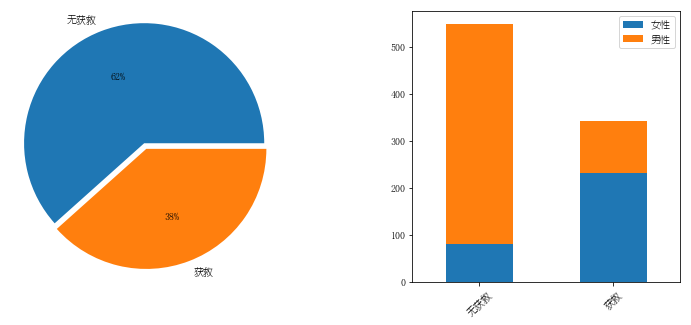

In [3]:
fig1 = plt.figure(figsize = (12,5))
ax1 = fig1.add_subplot(1,2,1)

count_surv = data['Survived'].value_counts()
ax1.pie(count_surv.values,labels = ['无获救','获救'],autopct='%.0f%%',explode = [0.05,0])
plt.axis('equal')

ax2 = fig1.add_subplot(1,2,2)
sex_male = data['Survived'][data['Sex']== 'male'].value_counts()
sex_female = data['Survived'][data['Sex']== 'female'].value_counts()
df_sex = pd.DataFrame({'男性':sex_male,'女性':sex_female})
df_sex.plot(kind = 'bar',stacked = True,ax = ax2)
ax2.set_xticklabels(['无获救','获救'])
plt.xticks(rotation=45)

plt.subplots_adjust(wspace=0.5)

#### 这里探索的是登船港口是否有相关关系，可以看出在S这个地点登船人数最多，获救的人数也最多，这里看不出有什么特别关系

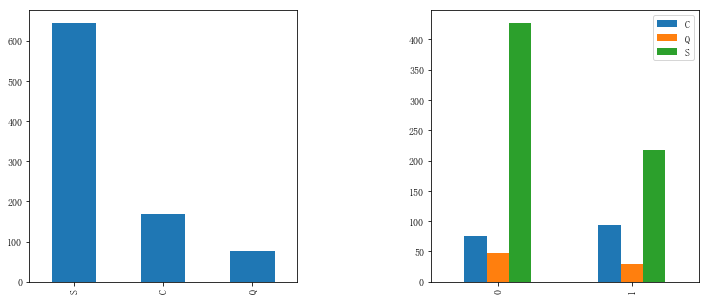

In [4]:
fig2 = plt.figure(figsize = (12,5))
ax1 = fig2.add_subplot(1,2,1)

embarked = data['Embarked'].value_counts()
embarked.plot(kind = 'bar',ax = ax1)

ax2 = fig2.add_subplot(1,2,2)
embarked_s = data['Survived'][data['Embarked']=='S'].value_counts()
embarked_c = data['Survived'][data['Embarked']=='C'].value_counts()
embarked_q = data['Survived'][data['Embarked']=='Q'].value_counts()
df_embarked = pd.DataFrame({'S':embarked_s,'C':embarked_c,'Q':embarked_q,})
df_embarked.plot(kind = 'bar',ax = ax2)

plt.subplots_adjust(wspace = 0.5)

#### 观察得到，3等舱获救率是最低的，1等舱最高；3等舱总体年龄偏低，1等舱总体年龄偏高；年龄在16-32岁的人最多；0-16岁的儿童或青少年获救率相对是比较高的

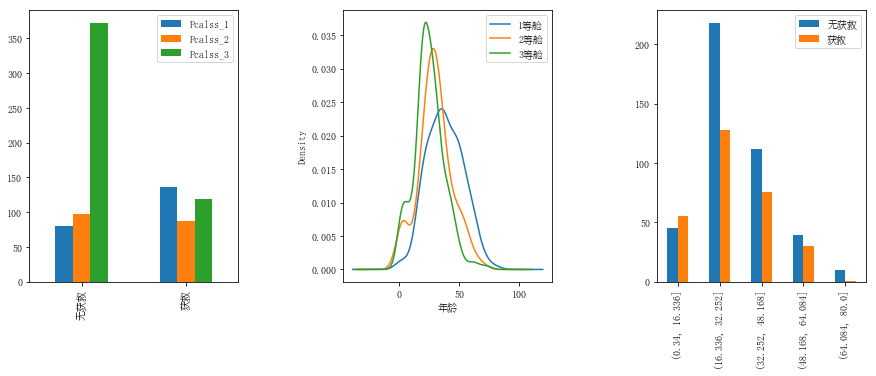

In [5]:
fig3 = plt.figure(figsize = (15,5))
ax1 = fig3.add_subplot(1,3,1)

pclass_1 = data['Survived'][data['Pclass']== 1].value_counts()
pclass_2 = data['Survived'][data['Pclass']== 2].value_counts()
pclass_3 = data['Survived'][data['Pclass']== 3].value_counts()
df_pclass = pd.DataFrame({'Pcalss_1':pclass_1,'Pcalss_2':pclass_2,'Pcalss_3':pclass_3})
df_pclass.plot(kind = 'bar',ax = ax1)
ax1.set_xticklabels(['无获救','获救'])

ax2 = fig3.add_subplot(1,3,2)
pclass1_age = data['Age'][data['Pclass'] == 1]
pclass1_age.plot(kind = 'Kde')
pclass2_age = data['Age'][data['Pclass'] == 2]
pclass2_age.plot(kind = 'Kde')
pclass3_age = data['Age'][data['Pclass'] == 3]
pclass3_age.plot(kind = 'kde',ax = ax2)
plt.legend(['1等舱','2等舱','3等舱'])
plt.xlabel('年龄')

ax3 = fig3.add_subplot(1,3,3)
data2 = data.copy()
data2['age_kind'] = pd.cut(data2['Age'],5)
age_unsurvived = data2['age_kind'][data2['Survived'] == 0].value_counts(sort = False)
age_survived = data2['age_kind'][data2['Survived'] == 1].value_counts()
df_age = pd.DataFrame({'获救':age_survived,'无获救':age_unsurvived})
df_age.plot(kind = 'bar',ax = ax3)

plt.subplots_adjust(wspace = 0.5)

#### 还可以探索更多的信息，但是在这里先省略掉

## 2、数据预处理

#### 查看数据总体情况，可以看出Age/Cabin有缺失值，其他都完整

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### 1）Name字段中看起来比较混乱，但是我们通过 value_counts()统计，观察发现   Mr/Miss/Mrs/Master这几种情况最多，其他的比较杂乱并且数量，在这里把其他情况转换为other，需要注意的是，截取出来的字段带有空格，要去空格。
#### 2)因为有SibSp及Parch，可以衍生出是否只是一个人乘船（alone），还是有cousin或者父母小孩，这些是否影响到生还率；另外还新增一个字段famnum，猜想亲人的个数可能也会影响生还率。
#### 3)Cabin这个字段观察到字段比较杂，是由字母及数字组成，缺失值很多，这里暂先不过多处理，只是把有记录的转为Yes，没有记录的转为No（这个设置还不是很合理），要先替换掉notnull，再替换null，否则全部都为YES。

In [7]:
data['lastname'] = data['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()

data.loc[(data['lastname'][data['lastname'] != 'Mr'][data['lastname'] != 'Miss'][data['lastname'] != 'Mrs'][data['lastname'] != 'Master']).index,'lastname'] = 'other'
data.loc[data['Cabin'].notnull(),'Cabin'] = 'Yes'
data.loc[data['Cabin'].isnull(),'Cabin'] = 'No'

data['famnum'] = data['SibSp']+data['Parch']
data.loc[data['famnum']==0,'alone'] = 1
data.loc[data['famnum']!=0,'alone'] = 0
data['alone'] = data['alone'].astype('int')

data.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lastname,famnum,alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,No,S,Mr,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,Yes,C,Mrs,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,No,S,Miss,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,Yes,S,Mrs,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,No,S,Mr,0,1


#### 年龄很明显是个很重要的因素，但是存在缺失值，要进行填充（中位数？众数？平均值？拉格朗日填充？这些听起来不太合理，所以用了简单线性回归模型拟合，但是这个模型拟合出来居然有负数(data['Age']< 0  存在True，不合理)，但年龄与这些字段也可能不是简单线性关系，可能是多元线性关系，或者不存在线性关系的，（但是我使用简单线性回归填充后再进行后续处理后提交：准确率为77%）

In [8]:
# 简单线性回归
# from sklearn.linear_model import LinearRegression
# agepre = data[['Age','Survived', 'Pclass', 'SibSp', 'Parch',
#               'Fare', 'famnum', 'alone']]
# agenull = agepre[agepre['Age'].isnull()].as_matrix()
# agenotnull = agepre[agepre['Age'].notnull()].as_matrix()
# lg = LinearRegression()
# lg.fit(agenotnull[:,1:],agenotnull[:,0])
# predict = lg.predict(agenull[:,1:])
# data.loc[data['Age'].isnull(),'Age'] = predict
# data['Age']< 0  

#### 试试多元线性回归，先假设为二元，记得做数据的归一化，因为多元相对于一元，如果多元次数很高，样本特征差距很大。data['Age'][data['Age']< 0]为空，感觉准确率相对于简单线性回归高一些

In [9]:
# 多元线性回归
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

agepre = data[['Age','Survived', 'Pclass', 'SibSp', 'Parch',
              'Fare', 'famnum', 'alone']]
agenull = agepre[agepre['Age'].isnull()].as_matrix()
agenotnull = agepre[agepre['Age'].notnull()].as_matrix()

poly_lg = Pipeline([
                    ('poly',PolynomialFeatures(degree = 2)),
                    ('std_scale',StandardScaler()),
                    ('lin_reg',LinearRegression())]) 

poly_lg.fit(agenotnull[:,1:],agenotnull[:,0])
predict = poly_lg.predict(agenull[:,1:])
data.loc[data['Age'].isnull(),'Age'] = predict

#### 然后观察数据，发现Age和Fare这两个字段差异比较大，所以进行归一化

In [10]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
stand.fit(data['Age'].values.reshape(-1,1))
data['Age_scale'] = stand.transform(data['Age'].values.reshape(-1,1))
stand.fit(data['Fare'].values.reshape(-1,1))
data['Fare_scale'] = stand.transform(data['Fare'].values.reshape(-1,1))

#### dummy将分类变量转为指示变量，因为逻辑回归里要训练的特征都是数值型的，传入字符串是不可以的。另一种做法是直接替换为某个数值来作为标记，但是本身是没有数值意义的。

In [11]:
Sex_dummy = pd.get_dummies(data['Sex'],prefix = 'Sex')
Embarked_dummy = pd.get_dummies(data['Embarked'],prefix = 'Embarked')
lastname_dummy = pd.get_dummies(data['lastname'],prefix = 'lastname')

data_drop = data.drop(['Name','Ticket','Cabin','Embarked','lastname','Sex','Age','Fare','PassengerId'],axis = 1)
X_key = pd.concat([data_drop,Sex_dummy,Embarked_dummy,lastname_dummy,data['PassengerId']],axis = 1)
#放在后面'PassengerId'

X =X_key.as_matrix()
X_key.iloc[:,:].head()

,Survived,Pclass,SibSp,Parch,famnum,alone,Age_scale,Fare_scale,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,lastname_Master,lastname_Miss,lastname_Mr,lastname_Mrs,lastname_other,PassengerId
0,0,3,1,0,1,0,-0.549418,-0.502445,0,1,0,0,1,0,0,1,0,0,1
1,1,1,1,0,1,0,0.627079,0.786845,1,0,1,0,0,0,0,0,1,0,2
2,1,3,0,0,0,1,-0.255294,-0.488854,1,0,0,0,1,0,1,0,0,0,3
3,1,1,1,0,1,0,0.406486,0.420730,1,0,0,0,1,0,0,0,1,0,4
4,0,3,0,0,0,1,0.406486,-0.486337,0,1,0,0,1,0,0,1,0,0,5


## 3、建模
#### 这里建模采用逻辑回归，因为很明显titanic是一个是否生还的二分类的问题，但是也可以采用其他模型的。
#### 第一列为生还结果的值，第二列到倒数第二列为特征值，最后一列为乘客标记，留在这里似乎没什么用，但是也可以保留提取出跟预测结果有偏差的数据。
#### 如果把所有数据拿来直接训练，无法预知模型的好坏，所以就需要使用train_test_split，一部分作为训练数据，一部分作为测试数据。

In [12]:
from sklearn.linear_model import LogisticRegression
# lgr = LogisticRegression()
# lgr.fit(X[:,1:-1],X[:,0])
# coef = pd.DataFrame({'特征':X_key.columns[1:-1],'系数':lgr.coef_.T[:,0]})
# coef

#### fit需要传入都是矩阵，如果是向量也要转换为矩阵
#### 我们可以查看一下预测准确率（R-score）为82%左右，

In [13]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split((X_key.iloc[:,1:-1]),(X_key.iloc[:,0]))

lgrs = LogisticRegression()
lgrs.fit(X_train.as_matrix(),y_train.as_matrix())
predict = lgrs.predict(X_test)
lgrs.score(X_test,y_test)

0.8340807174887892

#### 查看下各个系数与字段之间的关系，排序后，可以发现master称呼的生还率最高，女性的生还率也非常高，另外与pclass(乘客等级)相关度最低，这个有点奇怪，成人男子生还率也很低，这个比较合理，年龄居然负相关，有点不太合理，这里猜想：如果把年龄划分为小组会不会准确率高一些。

In [14]:
coef_info = pd.DataFrame({'name':X_key.columns[1:-1],'coef':lgrs.coef_[0]})
coef_info.sort_values(by = 'coef',ascending = False)

,coef,name
12,1.824020,lastname_Master
7,1.713986,Sex_female
15,0.703129,lastname_Mrs
9,0.674191,Embarked_C
10,0.436794,Embarked_Q
11,0.381360,Embarked_S
6,0.186374,Fare_scale
13,0.152920,lastname_Miss
8,-0.048836,Sex_male
2,-0.071359,Parch


#### learning-curve  是否过拟合或欠拟合
#### 训练集上的分数越来越高，样本越多，训练的模型对于训练样本准确性越大，但是到一定程度，趋于平缓
#### 测试集上的分数逐渐下降，中间有一段两条曲线的差距很大，高方差，似乎过拟合，随着样本的增多，两者间距又趋于较为平稳状态，总而言之，学习曲线看起来不太好看，猜想：新增样本或新增特征或许会好些

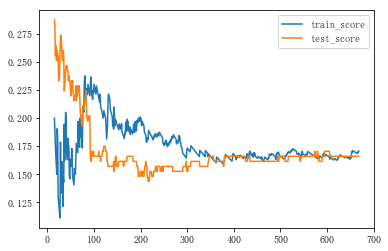

In [15]:
from sklearn.metrics import mean_squared_error
def learning_curve(modle,Xtrain,Xtest,ytrain,ytest):
    train_score = []
    test_score = []
    for i in range(15,1+len(Xtrain)):
        modle.fit(Xtrain[:i],ytrain[:i])
        train_predict = modle.predict(Xtrain[:i])
        tr_score = mean_squared_error(y_train[:i],train_predict)
        train_score.append(tr_score)
        
        test_predict = modle.predict(Xtest)
        te_score = mean_squared_error(y_test,test_predict)
        test_score.append(te_score)
        
    plt.plot([i for i in range(15, len(X_train)+1)],train_score,label = 'train_score')
    plt.plot([i for i in range(15, len(X_train)+1)],test_score,label = 'test_score')
    plt.legend()
    
learning_curve(LogisticRegression(),X_train,X_test,y_train,y_test)

#### test数据进行预测，这里test的数据要跟train的数据做一样的处理

In [16]:
data_test = pd.read_csv('C:/Users/Witsan/WitsanFolder/Data/Titanic/test.csv',engine = 'python')
data_test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
data_test['lastname'] = data_test['Name'].str.split(',',expand = True)[1].str.split('.',expand = True)[0].str.strip()

data_test.loc[(data_test['lastname'][data_test['lastname'] != 'Mr'][data_test['lastname'] != 'Miss'][data_test['lastname'] != 'Mrs'][data_test['lastname'] != 'Master']).index,'lastname'] = 'other'

data_test['famnum'] = data_test['SibSp']+data_test['Parch']
data_test.loc[data_test['famnum']==0,'alone'] = 1
data_test.loc[data_test['famnum']!=0,'alone'] = 0
data_test['alone'] = data_test['alone'].astype('int')

data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,lastname,famnum,alone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,0,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,0,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs,2,0


In [18]:
from sklearn.linear_model import LinearRegression
agepre = data_test[['Age', 'Pclass', 'SibSp', 'Parch',
              'Fare', 'famnum', 'alone']].copy()
data_test.loc[data_test['Fare'].isnull(),'Fare'] = np.mean(agepre['Fare'])
agepre.loc[agepre['Fare'].isnull(),'Fare'] = np.mean(agepre['Fare'])
agenull = agepre[agepre['Age'].isnull()].as_matrix()
agenotnull = agepre[agepre['Age'].notnull()].as_matrix()
lg_test = LinearRegression()
lg_test.fit(agenotnull[:,1:],agenotnull[:,0])
predict = lg_test.predict(agenull[:,1:])
data_test.loc[data_test['Age'].isnull(),'Age'] = predict

In [19]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 14 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           418 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
lastname       418 non-null object
famnum         418 non-null int64
alone          418 non-null int32
dtypes: float64(2), int32(1), int64(5), object(6)
memory usage: 44.2+ KB


In [20]:
from sklearn.preprocessing import StandardScaler
stand = StandardScaler()
stand.fit(data_test['Age'].values.reshape(-1,1))
data_test['Age_scale'] = stand.transform(data_test['Age'].values.reshape(-1,1))
stand.fit(data_test['Fare'].values.reshape(-1,1))
data_test['Fare_scale'] = stand.transform(data_test['Fare'].values.reshape(-1,1))

In [21]:
Sex_dummy = pd.get_dummies(data_test['Sex'],prefix = 'Sex')
Embarked_dummy = pd.get_dummies(data_test['Embarked'],prefix = 'Embarked')
lastname_dummy = pd.get_dummies(data_test['lastname'],prefix = 'lastname')

data_test_drop = data_test.drop(['Name','Ticket','Cabin','Embarked','lastname','Sex','Age','Fare','PassengerId'],axis = 1)
X_key_test = pd.concat([data_test_drop,Sex_dummy,Embarked_dummy,lastname_dummy],axis = 1)

X_testdata =X_key_test.as_matrix()
X_key_test.iloc[:,:].head()

,Pclass,SibSp,Parch,famnum,alone,Age_scale,Fare_scale,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,lastname_Master,lastname_Miss,lastname_Mr,lastname_Mrs,lastname_other
0,3,0,0,0,1,0.398798,-0.498407,0,1,0,1,0,0,0,1,0,0
1,3,1,0,1,0,1.361085,-0.513274,1,0,0,0,1,0,0,0,1,0
2,2,0,0,0,1,2.515829,-0.465088,0,1,0,1,0,0,0,1,0,0
3,3,0,0,0,1,-0.178575,-0.483466,0,1,0,0,1,0,0,1,0,0
4,3,1,1,2,0,-0.563489,-0.418471,1,0,0,0,1,0,0,0,1,0


In [22]:
predict_test = lgrs.predict(X_testdata)

In [23]:
result_test = pd.DataFrame({'PassengerId':data_test['PassengerId'],'Survived':predict_test})
result_test.to_csv("results.csv",index = False)

####  还需要做的工作：模型融合；特征调整
#### 年龄使用简单线性回归或者多元线性回归预测填充，再进行后续处理，提交的结果没有太大的差别，都为77%

![avatar](titanic_second.PNG)